<h1><center><font size='25'>U.S Stock Market Price Forecasting with Skforecast package</font></center></h1>

<center><b>Son Hai Le, Inspired by <a href="https://www.cienciadedatos.net/documentos/py41-forecasting-cryptocurrency-bitcoin-machine-learning-python.html">the Article of Joaquín Amat Rodrigo, Javier Escobar Ortiz</a> </b></center>


<center><i>March, 2023 (last update September, 2023)</i></center>

+ [Web apps: U.S finance dashboard](https://lhs-inc-us-finance-investigation.streamlit.app/)
+ [Skforecast: time series forecasting with Python and Scikit-learn](https://www.cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html)
+ [Forecasting electricity demand with Python](https://www.cienciadedatos.net/documentos/py29-forecasting-electricity-power-demand-python.html)
+ [Forecasting web traffic with machine learning and Python](https://www.cienciadedatos.net/documentos/py37-forecasting-web-traffic-machine-learning.html)
+ [Forecasting time series with gradient boosting: Skforecast, XGBoost, LightGBM and CatBoost](https://www.cienciadedatos.net/documentos/py39-forecasting-time-series-with-skforecast-xgboost-lightgbm-catboost.html)
+ [Prediction intervals in forecasting models](https://www.cienciadedatos.net/documentos/py42-forecasting-prediction-intervals-machine-learning.html)

## Introduction
<br>

- A time series: ordered data spaced at equal or unequal intervals
- The [forecasting](https://joaquinamatrodrigo.github.io/skforecast/latest/quick-start/introduction-forecasting.html): predicting the future value of a time series (based on past behavior (autoregressive) or external variables or both)

==> However, not easy

- To modelling a forecaster: 
<p style="text-align: center;"> $Forecast = pattern + unexplained\;variance$ </p>
    + The first term: everything that has a repetitive character over time (trend, seasonality, cyclical factors...)
    + The second term: everything that influences the response variable but is not captured (explained) by the past of the time series

==> The greater the importance of the first term relative to the second, the greater the probability of success when attempting to create autoregressive forecasting models

==> As the second term gains weight, it becomes necessary to incorporate additional variables (if any) into the model to help explain the observed behavior.

- Purpose of this document: 
    + Replicate the work of [Joaquín Amat Rodrigo, Javier Escobar ]("https://www.cienciadedatos.net/documentos/py41-forecasting-cryptocurrency-bitcoin-machine-learning-python.html")
    + Attempt to predict the daily closing price of a U.S market stock (i.e., MMM company)
    + Try to diagnose the model and improve the performance of the model


- The document consists of 2 parts:
    + Part 1: Replicate the work of [Joaquín Amat Rodrigo, Javier Escobar ]("https://www.cienciadedatos.net/documentos/py41-forecasting-cryptocurrency-bitcoin-machine-learning-python.html") with one-step-ahead forecasting
    + Part 2: Try to diagnose the model and improve the performance of the model with multi-step-ahead forecasting

## Use Case
- Generate a forecasting model capable of predicting the price of the stock of MMM company
- Data feature:
    + Opening (Open), closing (Close), maximum (High), and minimum (Low) prices
    + Duration: 2013-04-29 to 2021-31-12

## Libraries
<br>

The libraries used in this document are:

In [2]:
# Data manipulation
# ==============================================================================
import pandas as pd
import numpy as np
import datetime

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('ggplot')

# colors
# ==============================================================================
palette_btc = {'orange': '#f7931a',
               'white' : '#ffffff',
               'gray'  : '#4d4d4d',
               'blue'  : '#0d579b',
               'green' : '#329239'
              }

# Modelling and Forecasting
# ==============================================================================
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error

## Data
- Downloaded by using my own web apps [US-finance-dashboard](https://lhs-inc-us-finance-investigation.streamlit.app/)
- Useful for downloading historical U.S stock data from the [Coinmarketcap](https://coinmarketcap.com/) website. 
- The information in each column:
    + `date`: date of the record.
    + `open`: the opening price (USD)
    + `high`: the maximum price of the day (USD)
    + `low`: the minimum price of the day (USD).
    + `close`: the closing price (USD)
    + `volume`: the sum of actual trades made during the day (USD)

In [3]:
# Data open
# ==============================================================================

# Transform collected data into a dataframe
data = pd.read_csv('MMM_price_history.csv')
data.sort_values(by='date', ascending=True, inplace=True)

pd.set_option('display.max_columns', None)
display(data)
pd.reset_option('display.max_columns')

,date,open,high,low,close,volume,adjclose,dividends
0,2013-04-29,103.910004,104.199997,102.889999,103.830002,2903700,77.111168,0.0
1,2013-04-30,103.980003,104.739998,102.970001,104.709999,3768800,77.764679,0.0
2,2013-05-01,104.779999,105.120003,104.419998,104.550003,3258900,77.645897,0.0
3,2013-05-02,105.040001,106.379997,104.910004,106.040001,3119500,78.752449,0.0
4,2013-05-03,106.959999,108.599998,106.849998,107.830002,3013100,80.081795,0.0
...,...,...,...,...,...,...,...,...
2182,2021-12-27,175.149994,176.729996,174.910004,176.699997,1183000,167.297440,0.0
2183,2021-12-28,176.839996,178.500000,176.750000,177.639999,1618900,168.187408,0.0
2184,2021-12-29,177.479996,178.889999,177.229996,178.410004,1221900,168.916458,0.0
2185,2021-12-30,178.869995,179.179993,177.580002,177.639999,1067300,168.187408,0.0


In [4]:
# Data preparation
# ==============================================================================
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d %H:%M:%S')
data = data.set_index('date')
data = data.asfreq('D')
data = data.sort_index()
# Due to weekend and holidays, the data may be missing. We fill the missing data with the previous value
data.fillna(method='ffill', inplace=True)

When setting a frequency with the `asfreq()` method, **Pandas** fills the gaps that may exist in the time series with the value of `Null` to ensure the indicated frequency. Therefore, it should be checked if missing values have appeared after this transformation.

In [5]:
print(f'Number of rows with missing values: {data.isnull().any(axis=1).mean()}')
# find rows with missing values
# mask = data.isnull().any(axis=1)
# rows_with_missing_values = data[mask]
# print(rows_with_missing_values)

Number of rows with missing values: 0.0


## Graphic exploration
When generate a forecasting model:
 + Plotting the time series values: allows identifying patterns such as trends and seasonality

### [Candlestick chart](https://en.wikipedia.org/wiki/Candlestick_chart)
- A style of financial chart used to describe price movements of a security, derivative, or currency
    + The thick body: the variation between the opening and closing price for a period
    + The shadows: the minimum and maximum values reached during that period.

<center><img src="Candlestick.svg" style='width: 300px; padding-bottom: 5px' align='center'></center> 

<center><font size='4.5'> <i>Scheme of the 2 kinds of basic candlestick chart. Source: <a href="https://en.wikipedia.org/wiki/Candlestick_chart#/media/File:Candlestick_chart_scheme_03-en.svg">Wikipedia</a>.</i></font></center>

In [6]:
# Interactive candlestick chart with Plotly
# ==============================================================================
candlestick = go.Candlestick(
                  x     = data.index,
                  open  = data.open,
                  close = data.close,
                  low   = data.low,
                  high  = data.high,
              ) 

fig = go.Figure(data=[candlestick])

fig.update_layout(
    width       = 900,
    height      = 450,
    title       = dict(text='<b>MMM/USD Chart</b>', font=dict(size=30)),
    yaxis_title = dict(text='Price (USD)', font=dict(size=15)),
    margin      = dict(l=10, r=20, t=80, b=20),
    xaxis_rangeslider_visible = False,
)

fig.show()

### Data distribution

The distribution of the MMM closing price, variable `close`, is shown:

Text(0.5, 0, 'Price (USD)')

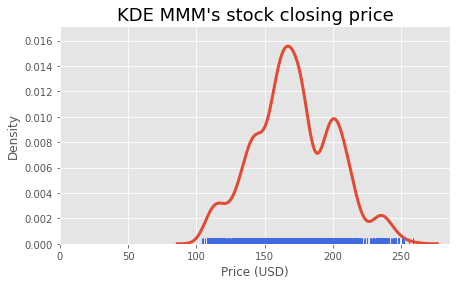

In [7]:
# KDE distribution of Bitcoin closing price
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 4))
p = sns.kdeplot(data=data, x='close', linewidth=3, ax=ax)
r = sns.rugplot(data=data, x='close', ax=ax,c='royalblue', clip_on=False)
p.set(xlim=(0, None))
p.set_title("KDE MMM's stock closing price", fontsize=18)
p.set_xlabel('Price (USD)')

- The study data:
    + A majority distribution of prices ranging from about over 100 (USD) to 220 (USD)

- Note:
    + Model a time series with a highly asymmetric distribution and distinct orders of magnitude over time: complicated
    Potential strategy: model changes (deltas) rather than direct values (more symmetric distribution)

### Price per year

In [8]:
# Locate corresponding data for each year
# ==============================================================================
years = list(data.index.year.unique())
df_plot = pd.DataFrame()

for year in years:
    
    year_open  = data.loc[data.index.year == year, 'open'][0]
    year_close = data.loc[data.index.year == year, 'close'][-1]
    year_low   = data.loc[data.index.year == year, 'low'].min()
    year_high  = data.loc[data.index.year == year, 'high'].max()
    
    df_plot[year] = pd.Series([year_open, year_close, year_low, year_high]) 
    
df_plot = df_plot.T
df_plot = df_plot.set_axis(['open', 'close', 'low', 'high'], axis=1)

# Calculate % change between the open and close price of the year
# ==============================================================================
df_plot['year_change'] = 100*(df_plot['close'] - df_plot['open']) / df_plot['open']
df_plot.head(3)

,open,close,low,high,year_change
2013,103.910004,140.250000,102.889999,140.429993,34.972568
2014,140.000000,164.320007,123.610001,168.160004,17.371434
2015,166.000000,150.639999,134.000000,170.500000,-9.253012


In [9]:
# Create a list of dicts with the % change annotations for the plot
# ==============================================================================
annotations_list = []
max_high = df_plot['high'].max()

for year in years:
    
    df_aux = df_plot.loc[df_plot.index == year,]
    loc_x  = pd.to_datetime(df_aux.index[0], format='%Y')
    loc_y  = df_aux['high'].values[0]/max_high + 0.01
    text   = '{:.1f}%'.format(df_aux['year_change'].values[0])
    
    annotation = dict(x=loc_x, y=loc_y, 
                      xref='x', yref='paper',
                      showarrow=False, xanchor='center', 
                      text=text)

    annotations_list.append(annotation)

# Interactive candlestick chart with Plotly
# ==============================================================================
candlestick = go.Candlestick(
                  x     = pd.to_datetime(df_plot.index, format='%Y'),
                  open  = df_plot.open,
                  close = df_plot.close,
                  low   = df_plot.low,
                  high  = df_plot.high
              )

fig = go.Figure(data=[candlestick])

fig.update_layout(
    width       = 800,
    height      = 350,
    title       = dict(text='<b>MMM/USD yearly chart</b>', font=dict(size=25)),
    yaxis_title = dict(text='Price (USD)', font=dict(size=13)),
    margin      = dict(l=0, r=20, t=55, b=20),
    xaxis_rangeslider_visible = False,
    annotations = annotations_list
)


### Annual, monthly and weekly seasonality

In [10]:
# Locate corresponding data for each month
# ==============================================================================
years = list(data.index.year.unique())
df_plot = pd.DataFrame()

for year in years:
    for month in range(12):
        
        start_date = pd.to_datetime(f'{year}-{month+1}-01', format='%Y-%m-%d')
        end_date = (start_date + pd.offsets.MonthBegin())
        mask = (data.index >= start_date) & (data.index < end_date)
        
        if not data.loc[mask, :].empty:
                        
            month_open  = data.loc[mask, 'open'][0]
            month_close = data.loc[mask, 'close'][-1]
            month_low   = data.loc[mask, 'low'].min()
            month_high  = data.loc[mask, 'high'].max()
            
            serie  = pd.Series([month_open, month_close, month_low, month_high])
            df_aux = pd.DataFrame(serie, columns=[f'{str(month+1).zfill(2)}-{year}'])
            
            if df_plot.empty:
                df_plot = df_aux.copy()
            else:
                df_plot = pd.concat([df_plot, df_aux], axis=1)

df_plot = df_plot.T
df_plot = df_plot.set_axis(['open', 'close', 'low', 'high'], axis=1)

In [11]:
# Boxplot chart for annual seasonality
# ==============================================================================

df_plot['month'] = pd.to_datetime(df_plot.index, format='%m-%Y').month

# fig 1 monthly boxplot
fig1 = px.box(df_plot.sort_values('month'), x='month', y='close',
              color_discrete_sequence=[palette_btc['green']])

# fig 2 line with median data for each month
df_median = pd.DataFrame(df_plot.groupby('month')['close'].median()).reset_index()
fig2 = px.line(df_median, x='month', y='close', markers=True,
               color_discrete_sequence=[palette_btc['gray']])

fig = go.Figure(data=fig1.data + fig2.data)

fig.update_layout(
    width       = 650,
    height      = 350,
    title       = dict(text='<b>MMM Price per month</b>', font=dict(size=25)),
    yaxis_title = dict(text='Price (USD)', font=dict(size=13)),
    xaxis       = dict(tickmode='linear'),
    xaxis_title = dict(text='month', font=dict(size=13)),
    margin      = dict(l=0, r=20, t=55, b=20)
)

In [12]:
# Boxplot chart for monthly seasonality
# ==============================================================================
data['day'] = pd.Series(data.index).dt.day.values

# fig 1 dayly boxplot
fig1 = px.box(data.sort_values('day'), x='day', y='close',
              color_discrete_sequence=[palette_btc['green']])

# fig 2 line with median data for each day
df_median = pd.DataFrame(data.groupby('day')['close'].median()).reset_index()
fig2 = px.line(df_median, x='day', y='close', markers=True,
               color_discrete_sequence=[palette_btc['gray']])

fig = go.Figure(data=fig1.data + fig2.data)

fig.update_layout(
    width       = 750,
    height      = 350,
    title       = dict(text='<b>MMM Price per day of the month</b>', font=dict(size=25)),
    yaxis_title = dict(text='Price (USD)', font=dict(size=13)),
    xaxis       = dict(tickmode='linear', tickangle=0, range=[0.5, 31.5]),
    xaxis_title = dict(text='day', font=dict(size=13)),
    margin      = dict(l=0, r=20, t=55, b=20)
)

In [13]:
# Boxplot chart for weekly seasonality
# ==============================================================================

data['weekday'] = data.index.day_of_week + 1

# fig 1 weekly boxplot
fig1 = px.box(data.sort_values('weekday'), x='weekday', y='close',
              color_discrete_sequence=[palette_btc['green']])

# fig 2 line with median data for each weekday
df_median = pd.DataFrame(data.groupby('weekday')['close'].median()).reset_index()
fig2 = px.line(df_median, x='weekday', y='close', markers=True,
               color_discrete_sequence=[palette_btc['gray']])

fig = go.Figure(data=fig1.data + fig2.data)

fig.update_layout(
    width       = 650,
    height      = 350,
    title       = dict(text='<b>MMM Price per day of the week</b>', font=dict(size=25)),
    yaxis_title = dict(text='Price (USD)', font=dict(size=13)),
    xaxis       = dict(tickmode='linear'),
    xaxis_title = dict(text='weekday', font=dict(size=13)),
    margin      = dict(l=0, r=20, t=55, b=20)
)

- Usually, time series with an autoregressive pattern:
    + Produce a repetitive shape (trend, seasonality, cyclical factors)
    + In the case of MMM' stock price:
        * A certain annual seasonality appears in April and May, with reaching the lowest price during the year (i.e., "Sell in May and go away"")
        * No seasonality appears in the monthly and weekly intervals, with very similar distributions

### Autocorrelation plots

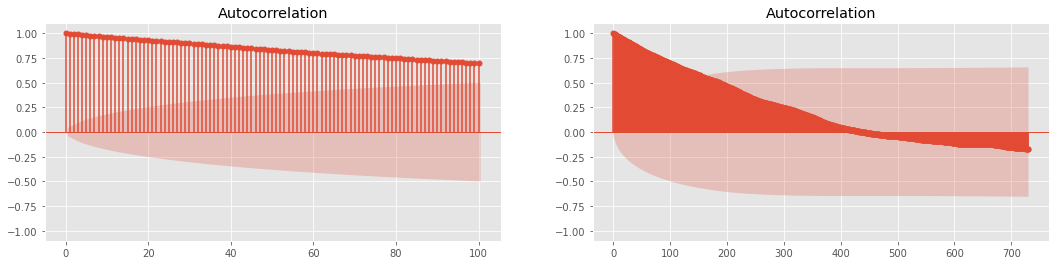

In [50]:
# Autocorrelation plot
# ==============================================================================
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))
axes = axes.flat
plot_acf(data.close, ax=axes[0], linewidth = 1, lags=100)
axes[0].set_ylim(-1.1, 1.1)
plot_acf(data.close, ax=axes[1], linewidth = 1, lags=730)
axes[1].set_ylim(-1.1, 1.1)
plt.show()

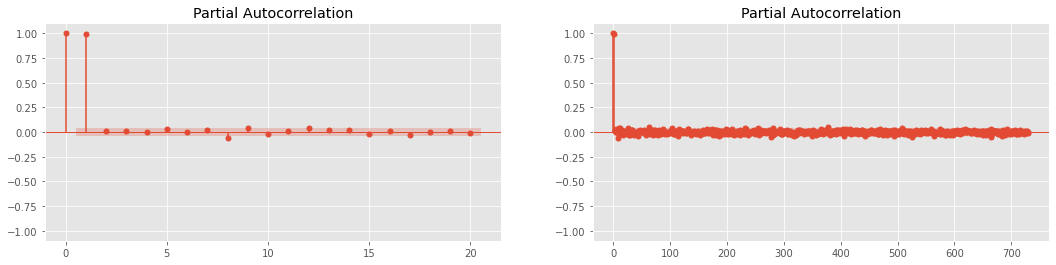

In [51]:
# Partial autocorrelation plot
# ==============================================================================
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))
axes = axes.flat
plot_pacf(data.close, ax=axes[0], lags=20, method='ywm',  linewidth = 1)
axes[0].set_ylim(-1.1, 1.1)
plot_pacf(data.close, ax=axes[1], lags=730, method='ywm',  linewidth = 1)
axes[1].set_ylim(-1.1, 1.1)
plt.show()

Some [comments](https://towardsdatascience.com/time-series-from-scratch-autocorrelation-and-partial-autocorrelation-explained-1dd641e3076f) about the autocorrelation plots and partial autocorrelation plots:

- If the ACF plot declines gradually and the PACF drops instantly, use Auto Regressive model.
- If the ACF plot drops instantly and the PACF declines gradually, use Moving Average model.
- If both ACF and PACF decline gradually, combine Auto Regressive and Moving Average models (ARMA).
- If both ACF and PACF drop instantly (no significant lags), it’s likely you won’t be able to model the time series.

==> In our case, use an Auto Regressive model is a suitable choice

## Baseline - Random walk simulation
When generating a predictive model:

    + The baseline model: simple model used for comparison with the models generated
    + The best estimate of the value $t_{n+1}$: the value $t_{n}$ plus an unpredictable change ([random walk theory](https://en.wikipedia.org/wiki/Random_walk_hypothesis))
==> Simplest viable model: uses the value of $t_{n}$ as the prediction for the $t_{n+1}$ value

==> Due to high fluctuation between years: use data from the **last two years**

In [14]:
# Selection of train-test dates
# ==============================================================================
start_train = '2020-01-01'
end_train = '2021-06-30'

print(f"Complete time series : {data.index.min()} --- {data.index.max()}  (n={len(data)})")
print(f"Train dates          : {data.loc[start_train:end_train].index.min()} --- {data.loc[start_train:end_train].index.max()}  (n={len(data.loc[start_train:end_train])})")
print(f"Test dates           : {data.loc[end_train:].index.min()} --- {data.loc[end_train:].index.max()}  (n={len(data.loc[end_train:])})")

Complete time series : 2013-04-29 00:00:00 --- 2021-12-31 00:00:00  (n=3169)
Train dates          : 2020-01-01 00:00:00 --- 2021-06-30 00:00:00  (n=547)
Test dates           : 2021-06-30 00:00:00 --- 2021-12-31 00:00:00  (n=185)


In [32]:
# Random walk simulation
# ==============================================================================
df_rw = data[['close']].copy()
df_rw['pred_close'] = df_rw['close'].shift(1)

# Test error
# ==============================================================================
y_true = df_rw.loc[end_train:, 'close']
y_pred = df_rw.loc[end_train:, 'pred_close']
MAE = mean_absolute_error(y_true, y_pred)

print(f'MAE: {MAE}')
display(df_rw.loc[end_train:,].head(4))

MAE: 1.0259457150021125


,close,pred_close
date,,
2021-06-30,198.630005,196.029999
2021-07-01,199.089996,198.630005
2021-07-02,199.889999,199.089996
2021-07-03,199.889999,199.889999


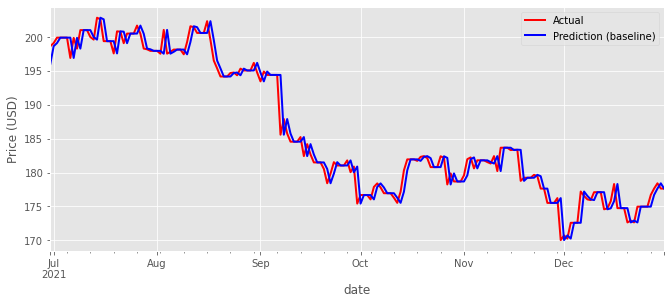

In [18]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4.5))
df_rw.loc[end_train:, 'close'].plot(ax=ax, linewidth=2, label='Actual',
                                    c='red')
df_rw.loc[end_train:, 'pred_close'].plot(ax=ax, linewidth=2, label='Prediction (baseline)',
                                    c='blue')
ax.set_ylabel('Price (USD)')
ax.legend()

In [33]:
# DataFrame models' test error
# ==============================================================================
df_errors = pd.DataFrame({'model': 'Base - Random Walk', 'lags': 1, 
                          'MAE': MAE, 'exog_variables': False},
                         index=[0])
df_errors

,model,lags,MAE,exog_variables
0,Base - Random Walk,1,1.025946,False


- MAE of baseline model: 1.026

==>Target: reduce the MAE of the models below 1.026

## Recursive autoregressive forecaster
-  Use an Autoregressive Forecaster ([ForecasterAutoreg](https://joaquinamatrodrigo.github.io/skforecast/latest/user_guides/autoregresive-forecaster.html)) with a [LightGBM](https://lightgbm.readthedocs.io/en/latest/) regressor, an implementation of the **Gradient Boosting** algorithm developed by Microsoft that usually achieves excellent results, is used to model the Bitcoin price.

- Previous sections:  absence of autocorrelation beyond the first lag

-> Verification: train several models with an increasing amount of lags and check if the error doesn't reduce

-> Done by [*backtesting*](https://joaquinamatrodrigo.github.io/skforecast/latest/user_guides/backtesting.html), using `steps = 1`

*Note: not rigorously necessary to perform any data preprocessing (`StandardScaler`, `MinMaxScaler`...) when working with models based on decision trees. [Example of forecasting with Scikit-learn pipelines](https://joaquinamatrodrigo.github.io/skforecast/latest/user_guides/sklearn-transformers-and-pipeline.html).*

In [24]:
# Forecasters backtest with different lags
# ==============================================================================
lags = [1, 7, 30]
metrics = []
predictions_list = []

for lag in lags:
    
    # Create forecaster
    forecaster = ForecasterAutoreg(
                     regressor     = LGBMRegressor(random_state=123),
                     lags          = lag,
                     transformer_y = None
                 )
    
    # Backtest test data, 1 step
    metric, predictions = backtesting_forecaster(
                              forecaster         = forecaster,
                              y                  = data.loc[start_train:, 'close'],
                              initial_train_size = len(data.loc[start_train:end_train, 'close']),
                              fixed_train_size   = True,
                              steps              = 1,
                              refit              = True,
                              metric             = 'mean_absolute_error',
                              verbose            = False
                          )
    
    metrics.append(metric)
    predictions_list.append(predictions)

c:\Users\84163\AppData\Local\Programs\Python\Python38\lib\site-packages\skforecast\model_selection\model_selection.py:370: RuntimeWarning:

The forecaster will be fit 184 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 


c:\Users\84163\AppData\Local\Programs\Python\Python38\lib\site-packages\skforecast\model_selection\model_selection.py:370: RuntimeWarning:

The forecaster will be fit 184 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 


c:\Users\84163\AppData\Local\Programs\Python\Python38\lib\site-packages\skforecast\model_selection\model_selection.py:370: RuntimeWarning:

The forecaster will be fit 184 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 




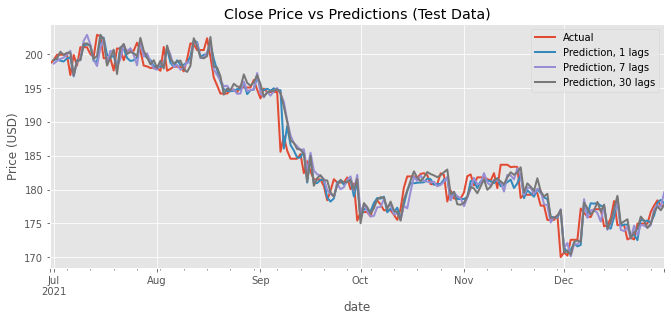

In [26]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4.5))
data.loc[end_train:, 'close'].plot(ax=ax, linewidth=2, label='Actual')

# Plot test predictions for different lags
for predictions, lag in zip(predictions_list, lags):
    predictions = predictions.rename(columns={'pred': f'Prediction, {lag} lags'})
    predictions.plot(ax=ax, linewidth=2)

ax.set_title('Close Price vs Predictions (Test Data)')
ax.set_ylabel('Price (USD)')
ax.legend()

In [34]:
# DataFrame models' test error
# ==============================================================================
model = 'LGBMRegressor'

df_errors = pd.concat([
                df_errors,
                pd.DataFrame({'model': model, 'lags': lags, 
                              'MAE': metrics, 'exog_variables': False})
                ]).reset_index(drop=True)

df_errors.sort_values(by='MAE')

,model,lags,MAE,exog_variables
0,Base - Random Walk,1,1.025946,False
1,LGBMRegressor,1,1.302892,False
3,LGBMRegressor,30,1.386864,False
2,LGBMRegressor,7,1.394841,False


The **MAE** show:

- None of the models improves the baseline despite incorporating more information from the past (number of lags)
- Alternatives: incorporate exogenous variables into the series

## Forecasting with exogenous variables
<br>

- Possible to have information about other variables, **whose future value is known**, and which can serve as additional predictors in the model
-  Typical examples:
    + Holidays (local, national...)
    + Month of the year
    + Day of the week
    + Time of day

- For this case: use the month of the year.

*Note: The `month` variables, although encoded as numbers, are categorical, so it is convenient to change the type with which they are stored. Since these variables do not have many levels, the One Hot Encoding transformation is used to incorporate them into the model.*

In [37]:
# Change of the categorical variables to category type
# ==============================================================================
data['month'] = data.index.month
data['month'] = data['month'].astype('category')

# One hot encoding
data = pd.get_dummies(data, columns=['month'])
data.head(2)

,open,high,low,close,volume,adjclose,dividends,day,weekday,month_1,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,,,,,,,,,,,
2013-04-29,103.910004,104.199997,102.889999,103.830002,2903700.0,77.111168,0.0,29,1,0,...,0,1,0,0,0,0,0,0,0,0
2013-04-30,103.980003,104.739998,102.970001,104.709999,3768800.0,77.764679,0.0,30,2,0,...,0,1,0,0,0,0,0,0,0,0


In [38]:
# All exogenous variables are selected, including those obtained  
# during one hot encoding.
# ==============================================================================
exog = [column for column in data.columns if column.startswith(('month'))]
print(exog)

['month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']


In [39]:
# Forecaster backtest with exogenous variables
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor        = LGBMRegressor(random_state=123),
                 lags             = 1,
                 transformer_y    = None,
                 transformer_exog = None
             )

# Backtest test data, 1 step
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data.loc[start_train:, 'close'],
                          exog               = data.loc[start_train:, exog],
                          initial_train_size = len(data.loc[start_train:end_train, 'close']),
                          fixed_train_size   = True,
                          steps              = 1,
                          refit              = True,
                          metric             = 'mean_absolute_error',
                          verbose            = False
                      )

c:\Users\84163\AppData\Local\Programs\Python\Python38\lib\site-packages\skforecast\model_selection\model_selection.py:370: RuntimeWarning:

The forecaster will be fit 184 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 




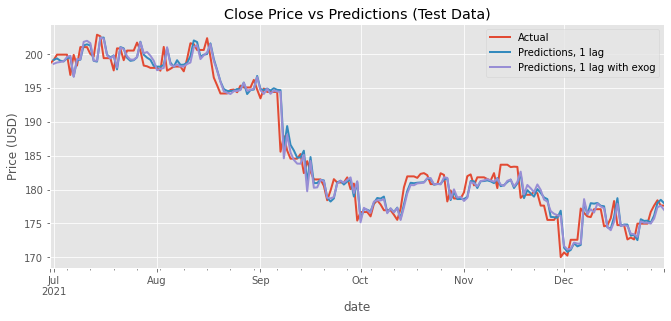

In [40]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4.5))
data.loc[end_train:, 'close'].plot(ax=ax, linewidth=2, label='Actual')

# Plot predictions 1 lag without exogenous variables
predictions_no_exog = predictions_list[0].rename(columns={'pred': f'Predictions, 1 lag'})
predictions_no_exog.plot(ax=ax, linewidth=2)

# Plot predictions 1 lag with exogenous variables
predictions_exog = predictions.rename(columns={'pred': f'Predictions, 1 lag with exog'})
predictions_exog.plot(ax=ax, linewidth=2)

ax.set_title('Close Price vs Predictions (Test Data)')
ax.set_ylabel('Price (USD)')
ax.legend();

In [41]:
# DataFrame models' test error
# ==============================================================================
model = 'LGBMRegressor'

df_errors = pd.concat([
                df_errors,
                pd.DataFrame({'model': model, 'lags': 1, 
                              'MAE': metric, 'exog_variables': True},
                             index=[4])
                ]).reset_index(drop=True)

df_errors.sort_values(by='MAE')

,model,lags,MAE,exog_variables
0,Base - Random Walk,1,1.025946,False
1,LGBMRegressor,1,1.302892,False
4,LGBMRegressor,1,1.308170,True
3,LGBMRegressor,30,1.386864,False
2,LGBMRegressor,7,1.394841,False


==> Incorporating exogenous variables DOES NOT increases the predictive capacity of the model in this case

## Conclusions

- Fail to find a model that improves the baseline with one-step-ahead predictions
- Early identification of the absence of this correlation by descriptive analysis avoids unnecessary modeling efforts
- With no autocorrelation: need exogenous variables capable of helping with the problem (e.g., the market sentiment through the analysis of tweets, impact of the so-called key opinion leaders, analysis of the most relevant news, etc. )
- Very simple to using machine learning models in forecasting problems thanks to the functionalities offered by [**Skforecast**](https://joaquinamatrodrigo.github.io/skforecast/latest/index.html).

## Future work in part 2
- Find a model that improves the baseline with multi-step-ahead predictions
- Hyperparameter tuning
- More exogenous variables